<a href="https://colab.research.google.com/github/deniseiras/Artificial-Intelligence/blob/main/CAP_421_Atividade_10_Recurrent_Neural_Networks_Denis_Eiras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Atividade 10

Author: Denis Eiras

Level: Doutorado

Register number: 406800/2021

Date: 29/11/2021

---

*RNN Exercise 1*

Create a classification model using the LSTM architecture to deal with the same problem from our previous test (given a GOES time series, with training elements ```time_steps```, *predict* the next element in the time series). When the predicted value is considered different (define a threshold) from the actual value, indicate a candidate disturbance point. 

For *training*, use the entire curve available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv 

For *testing*, use the second one, available at https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv

In [ ]:
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Activation

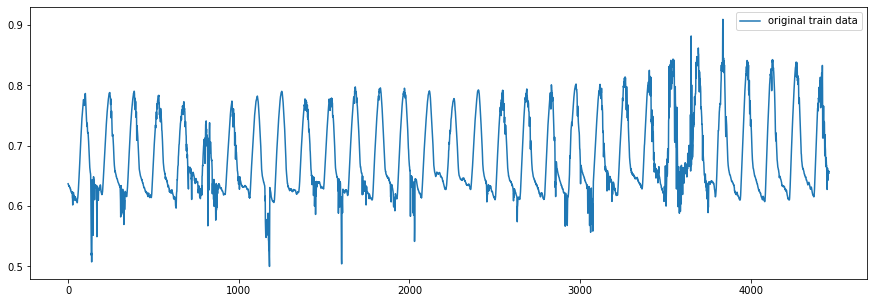

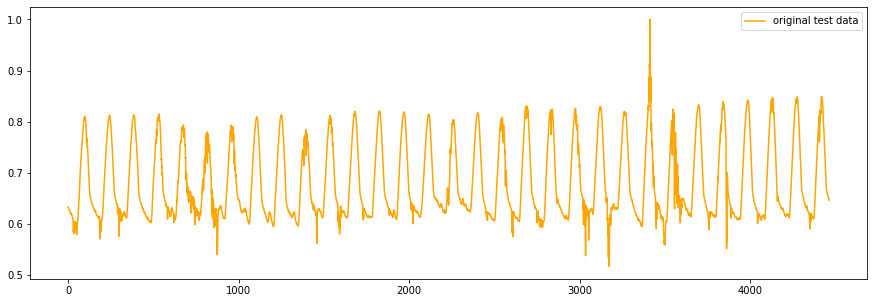

In [ ]:
# Prepare the input X and target Y
def get_XY(time_series, time_steps):
    Y_ind = np.arange(time_steps, len(time_series), time_steps)
    Y = time_series[Y_ind]
    rows_x = len(Y)
    X = time_series[range(time_steps*rows_x)]
    X = np.reshape(X, (rows_x, time_steps, 1))    
    return X, Y
 
# constants
url_X = 'https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_756_time_series.csv'
url_y = 'https://raw.githubusercontent.com/tkorting/remote-sensing-images/master/id_703_time_series.csv'

# load full data train
data_frame_X = read_csv(url_X, usecols=[1]) #, engine='python')
data_X = np.array(data_frame_X.values.astype('float32')).flatten()

# load full data test
data_frame_y = read_csv(url_y, usecols=[1]) #, engine='python')
data_y = np.array(data_frame_y.values.astype('float32')).flatten()

# normalize
max_val = max(data_X.max(), data_y.max())
data_X = data_X / max_val
data_y = data_y / max_val
N = len(data_X)

# create X -> y for training and for testing
time_steps = 24 # 12 corresponds to 2h of observations
X_train, y_train = get_XY(data_X, time_steps)
X_test, y_test = get_XY(data_y, time_steps)

# plot original data to check time-series
plt.figure(figsize=(15, 5))
plt.plot(data_X, label = 'original train data');
plt.legend()
plt.figure(figsize=(15, 5))
plt.plot(data_y, 'orange', label = 'original test data');
plt.legend()

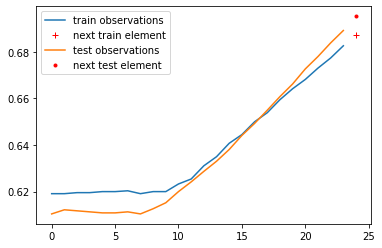

In [ ]:
# this is an example of how the training set is created
# given the 'blue curve', predict the 'red dot'
index = 38
plt.plot(X_train[index], label='train observations')
plt.plot(time_steps, y_train[index], 'r+', label='next train element' )
plt.legend();
plt.plot(X_test[index], label='test observations')
plt.plot(time_steps, y_test[index], 'r.', label='next test element' )
plt.legend();

Now, we define a LSTm model.

In [ ]:
# create the LSTM model

dense_units = 1
activation_lstm='relu'
activation_out = 'tanh'
callback = tf.keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=5, mode='min')


# train the model
epochs = 50
print(' Validation results: \n \n')
best_score = 99999
for validation in [ 'train = 10%', 'test']:
  for hidden_units in [1, 2, 3, 5, 10 ]:
    for batch_size in [1, 4, 8]:
      model = Sequential()
      model.add(LSTM(int(hidden_units), activation=activation_lstm, input_shape=(time_steps, 1), return_sequences=False))
      model.add(Dense(1))
      model.add(Activation(activation_out))
      model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

      if validation == 'train = 10%':
        history = model.fit(
          X_train, y_train,
          epochs = epochs,
          batch_size = batch_size,       # evitando o overfitting precoce
          validation_split=0.1,  # usando um validation split para um maior realismo ao testar sobre dados do mesmo conjunto
          shuffle=False,
          verbose=0,
          callbacks=[callback]
        )
      else:  
        history = model.fit(
          X_train, y_train,
          epochs = epochs,
          batch_size = batch_size,       # evitando o overfitting precoce
          validation_data = (X_test, y_test),
          shuffle=False,
          verbose=0
        )

      score = model.evaluate(X_test, y_test, batch_size=32, verbose=0)
      text_score = ' => Validation based on {}\t Hidden neurons = {}\t batch size: {}\tLOSS = {}\tMAE = {}'.format(validation, hidden_units, batch_size, score[0], score[1] )
      print(text_score)
      if score[1] < best_score:
        best_score = score[1]
        best_score_text = text_score
        best_model = model
        best_hist = history
        
print( '\n\n Best result: \n', best_score_text)


 Validation results: 
 

 => Validation based on train = 10%	 Hidden neurons = 1	 batch size: 1	LOSS = 0.0018245124956592917	MAE = 0.03588353842496872
 => Validation based on train = 10%	 Hidden neurons = 1	 batch size: 4	LOSS = 0.0016557893250137568	MAE = 0.03363068401813507
 => Validation based on train = 10%	 Hidden neurons = 1	 batch size: 8	LOSS = 0.02017868496477604	MAE = 0.1223340630531311
 => Validation based on train = 10%	 Hidden neurons = 2	 batch size: 1	LOSS = 0.005218863021582365	MAE = 0.06155293807387352
 => Validation based on train = 10%	 Hidden neurons = 2	 batch size: 4	LOSS = 0.0017289358656853437	MAE = 0.03477496653795242
 => Validation based on train = 10%	 Hidden neurons = 2	 batch size: 8	LOSS = 0.02017868496477604	MAE = 0.1223340630531311
 => Validation based on train = 10%	 Hidden neurons = 3	 batch size: 1	LOSS = 0.000407210347475484	MAE = 0.015160243958234787
 => Validation based on train = 10%	 Hidden neurons = 3	 batch size: 4	LOSS = 0.0018048331839963794	

In [ ]:
model = best_model
model.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 3)                 60        
                                                                 
 dense_22 (Dense)            (None, 1)                 4         
                                                                 
 activation_22 (Activation)  (None, 1)                 0         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


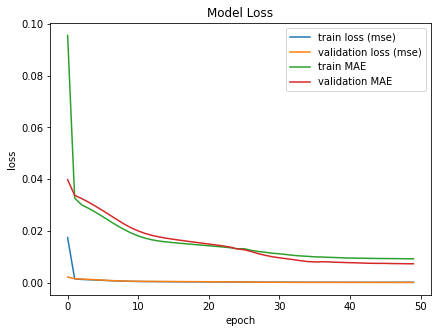

dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


In [ ]:
plt.figure(figsize=(15,5))

history = best_hist
plt.subplot(122)
plt.plot(history.history['loss'], label = 'train loss (mse)')
plt.plot(history.history['val_loss'], label = 'validation loss (mse)')
plt.plot(history.history['mean_absolute_error'], label = 'train MAE')
plt.plot(history.history['val_mean_absolute_error'], label = 'validation MAE')

plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

print(history.history.keys())

Threshold = 0.019815266132354736


Text(0.5, 1.0, 'Finding instants with high differences. Threshold = 0.0198')

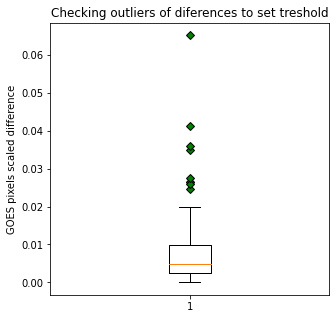

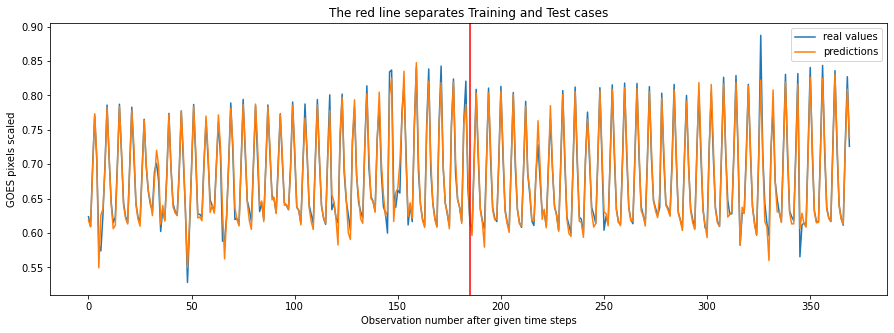

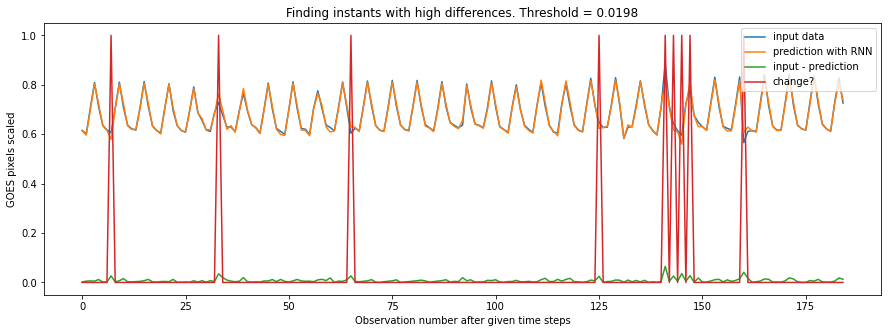

In [ ]:
# make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

all_data = np.append(y_train, y_test)
predictions = np.append(train_predict, test_predict)
difference = np.abs(y_test - test_predict.flatten())

# finding the threshold
green_diamond = dict(markerfacecolor='g', marker='D')
plt.figure(figsize=(5, 5))
plt.title('Checking outliers of diferences to set treshold')
plt.boxplot(difference, flierprops=green_diamond)
plt.ylabel('GOES pixels scaled difference')

# change_threshold = np.percentile(difference, 90)

upper_quartile = np.percentile(difference, 75)
lower_quartile = np.percentile(difference, 25)

iqr = upper_quartile - lower_quartile
upper_whisker = difference[difference<=upper_quartile+1.5*iqr].max()
change_threshold = upper_whisker
print("Threshold = {}".format(change_threshold))


# plot the results
plt.figure(figsize=(15, 5))
plt.plot(all_data, label = 'real values')
plt.plot(predictions, label = 'predictions') 
plt.axvline(x = len(y_train), color='r')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('The red line separates Training and Test cases')



plt.figure(figsize=(15, 5))
plt.plot(y_test, label = 'input data')
plt.plot(test_predict.flatten(), label = 'prediction with RNN')
plt.plot(difference, label = 'input - prediction')
plt.plot(difference > change_threshold, label = 'change?')
plt.legend()
plt.xlabel('Observation number after given time steps')
plt.ylabel('GOES pixels scaled')
plt.title('Finding instants with high differences. Threshold = {0:.4f}'.format(change_threshold))